<a href="https://colab.research.google.com/github/aninsung/Machine-Learning-Programming/blob/main/3%EC%A3%BC%EC%B0%A8/(CNN%2CLSTM%2CCNN%2BLSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [69]:
import pandas as pd

processedList = []
with open('/content/drive/MyDrive/기계학습프로그래밍/엑셀파일/WISDM_ar_v1.1_raw.txt') as file:
    for i, line in enumerate(file):
        try:
            line = line.strip().split(',')
            last = line[5].split(';')[0].strip()
            if last == '':
                continue  # 문제 있는 줄 무시
            temp = [line[0], line[1], line[2], line[3], line[4], last]
            processedList.append(temp)
        except Exception as e:
            print(f'Error at line {i}: {e}')

# DataFrame 변환
df = pd.DataFrame(processedList, columns=['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z'])
df[['X', 'Y', 'Z']] = df[['X', 'Y', 'Z']].astype(float)

print(df.shape)
print(df.head())
print(df['activity'].value_counts())


Error at line 281873: list index out of range
Error at line 281874: list index out of range
Error at line 281875: list index out of range
Error at line 537501: list index out of range
Error at line 832901: list index out of range
Error at line 1098209: list index out of range
(1098203, 6)
  user-id activity       timestamp         X          Y         Z
0      33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1      33  Jogging  49106062271000  5.012288  11.264028  0.953424
2      33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3      33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4      33  Jogging  49106332290000 -1.184970  12.108489  7.205164
activity
Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: count, dtype: int64


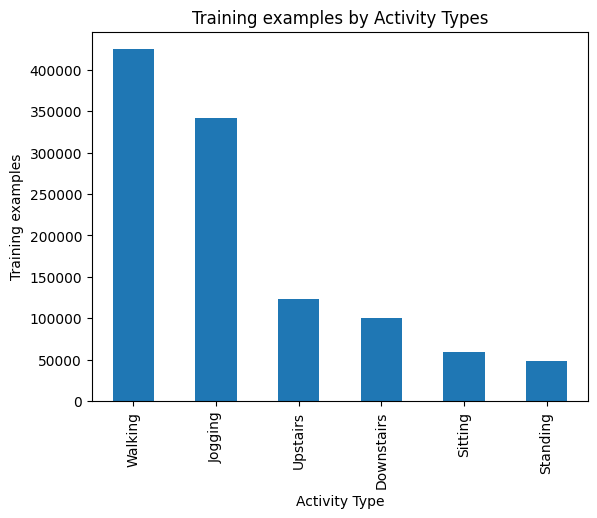

In [70]:
counts = df['activity'].value_counts(dropna=True)

if counts.empty:
    print("⚠️ activity 데이터가 비어 있습니다.")
else:
    counts.plot(kind='bar', title='Training examples by Activity Types')
    plt.xlabel('Activity Type')
    plt.ylabel('Training examples')
    plt.show()


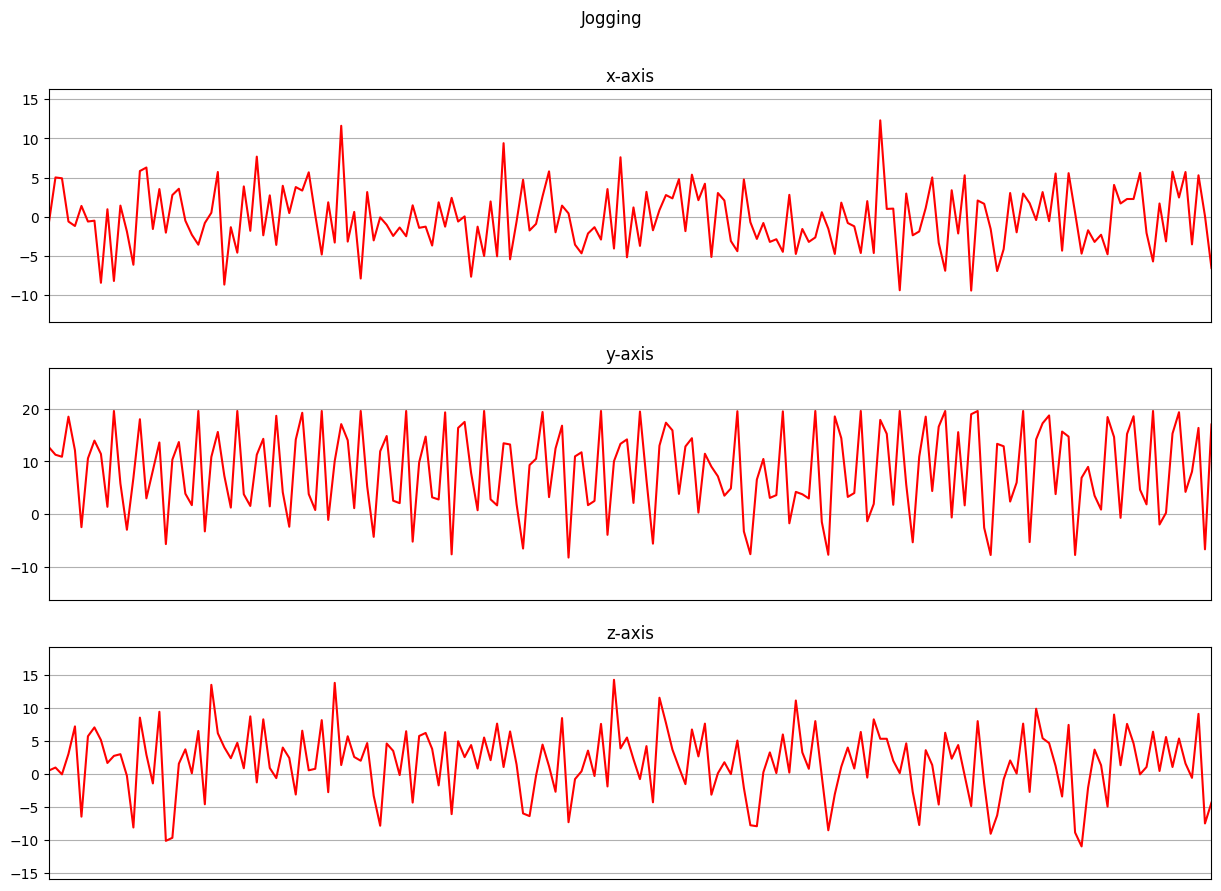

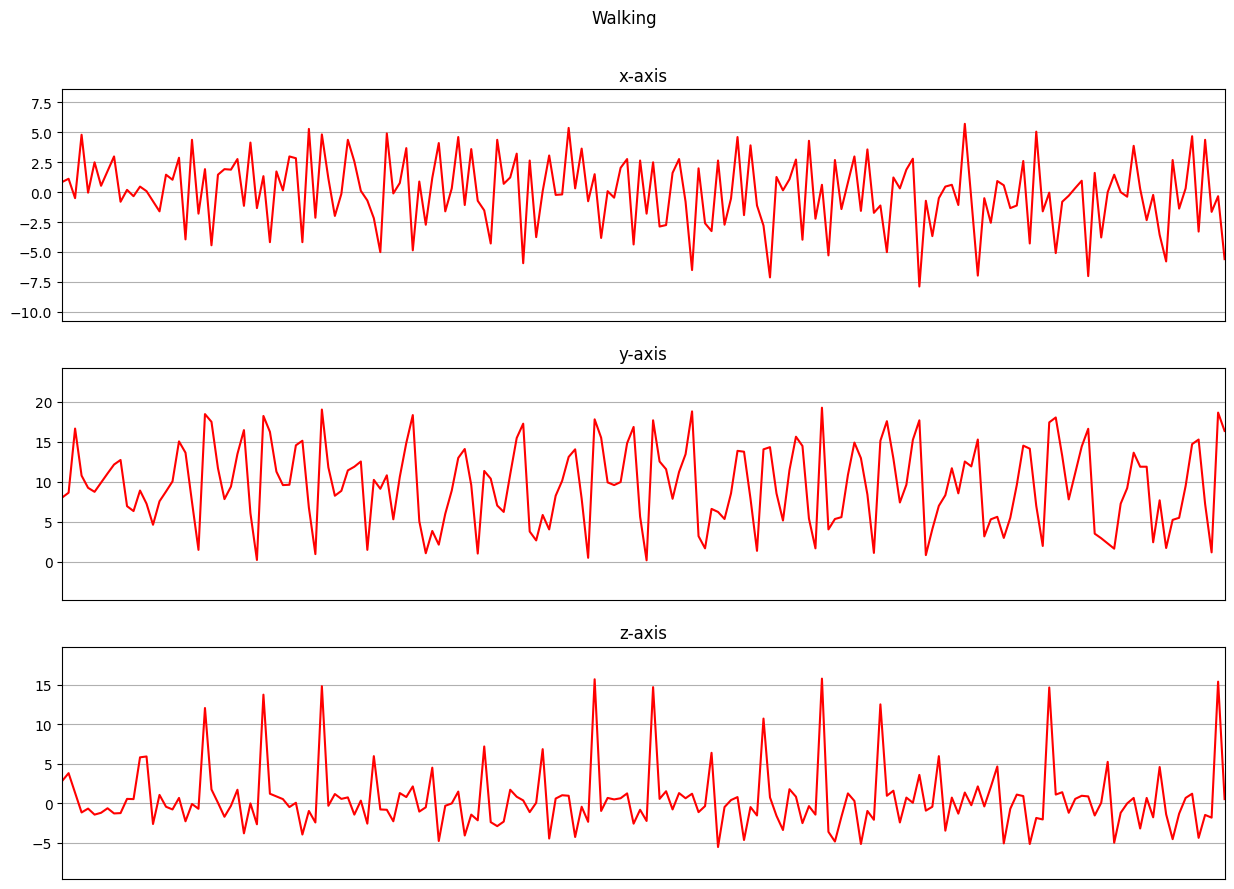

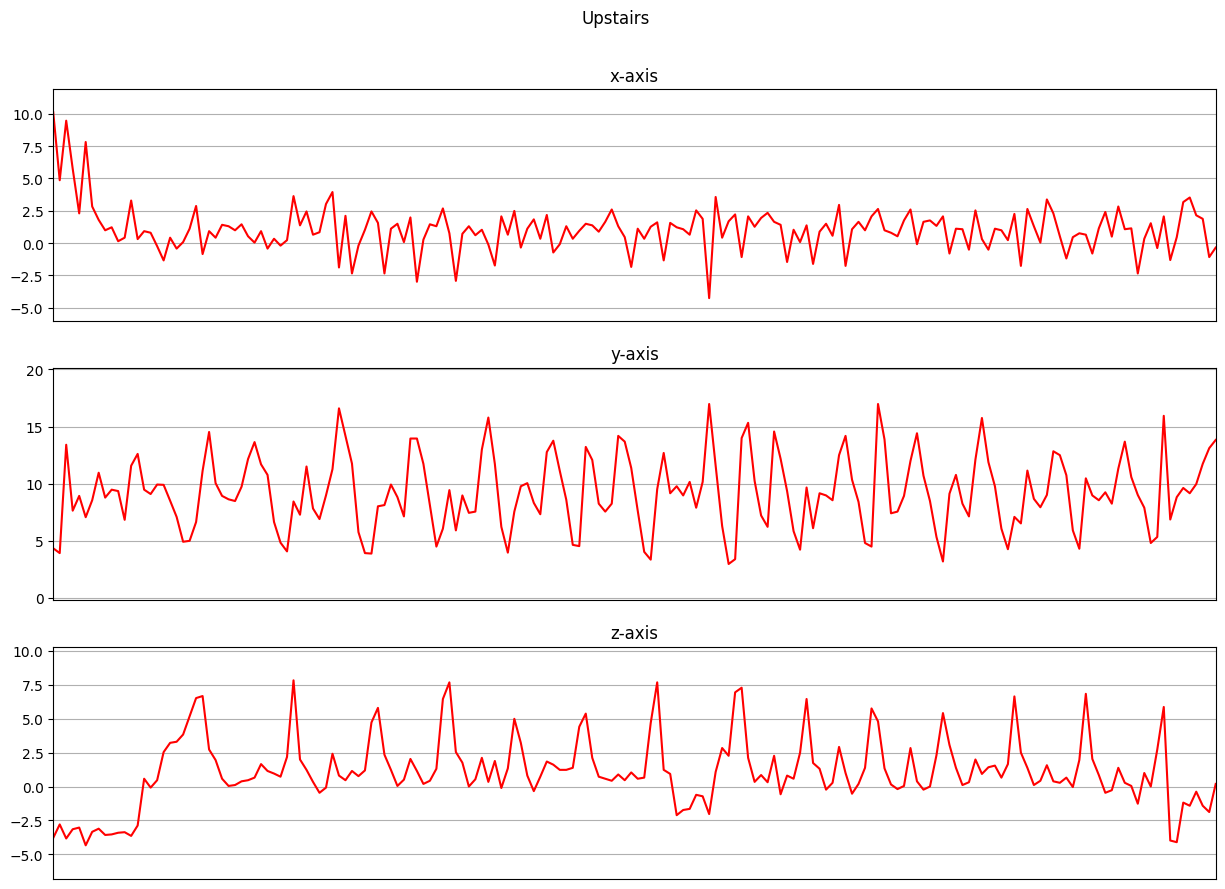

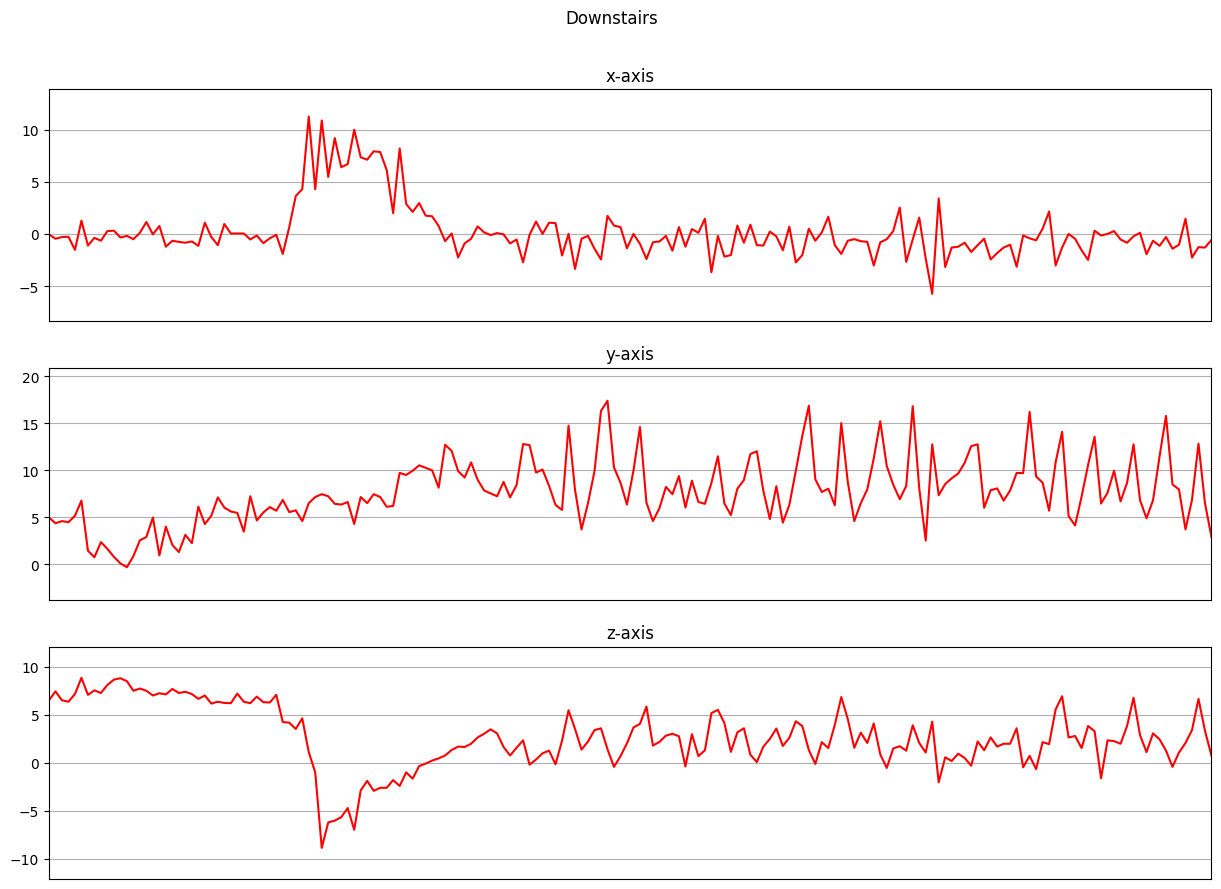

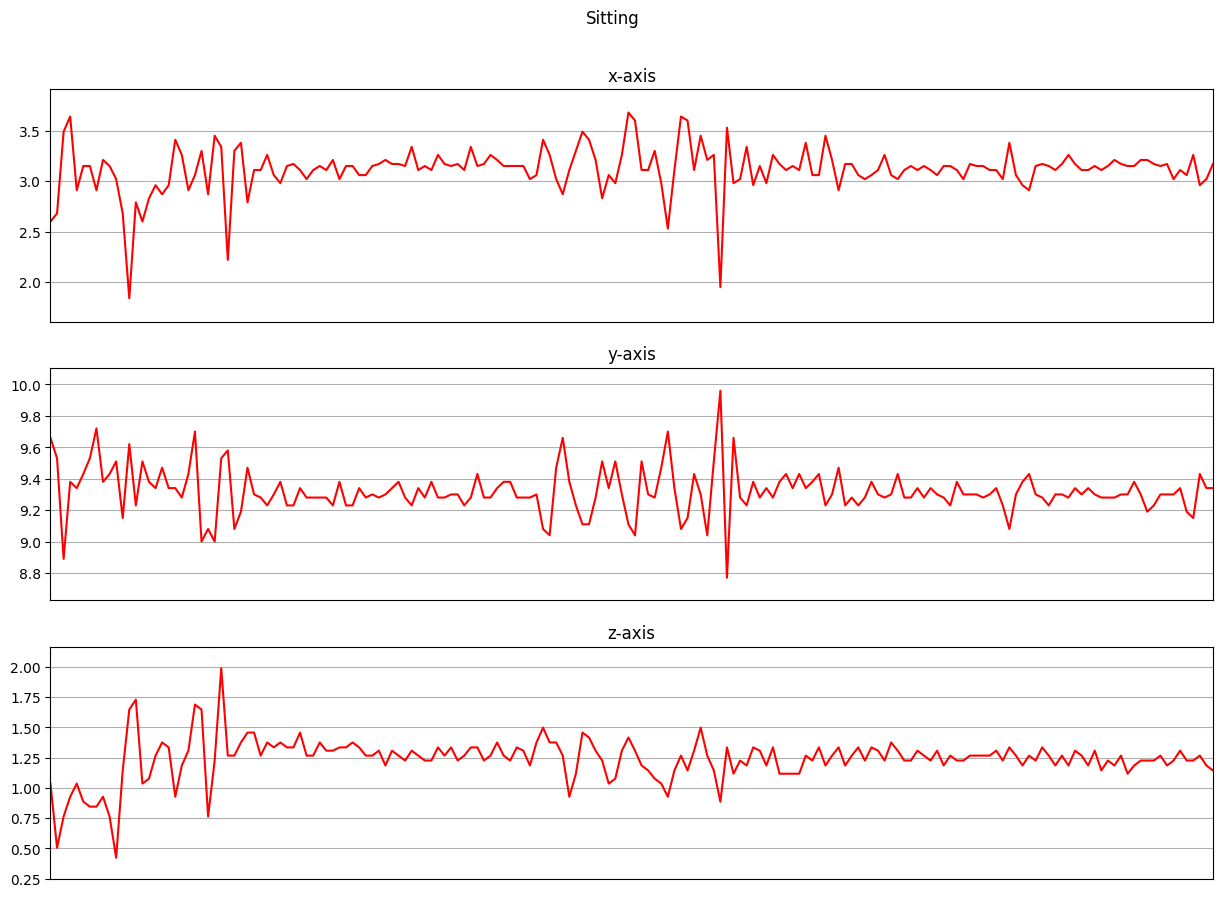

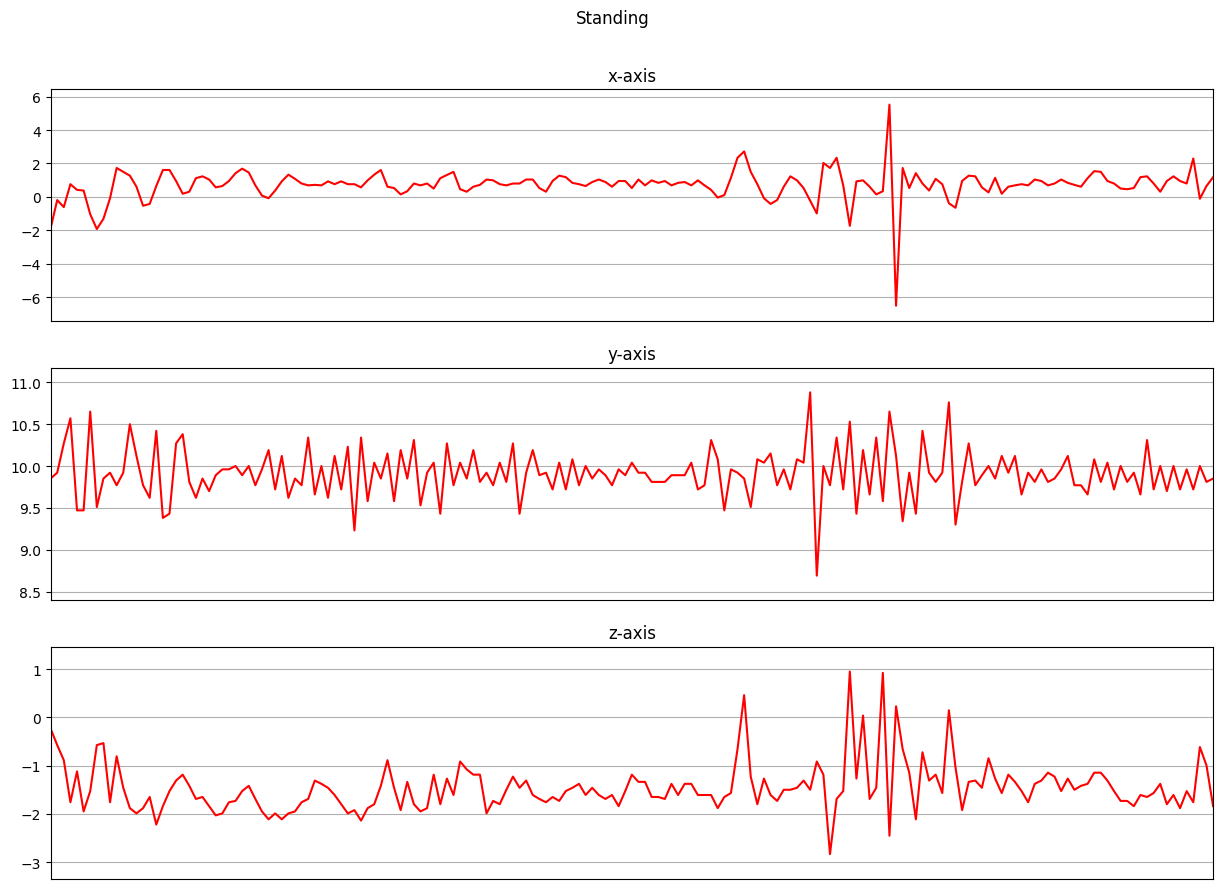

In [71]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in df['activity'].unique():
    limit = df[df['activity'] == activity][:180]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit['timestamp'], limit['X'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['Y'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['Z'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [72]:
label_encode = LabelEncoder()
df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel())
df

,user-id,activity,timestamp,X,Y,Z,activityEncode
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098198,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2
1098199,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2
1098200,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2
1098201,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2


In [73]:
interpolation_fn = interp1d(df['activityEncode'] ,df['Z'], kind='linear')
null_list = df[df['Z'].isnull()].index.tolist()
for i in null_list:
    y = df['activityEncode'][i]
    value = interpolation_fn(y)
    df['Z']=df['Z'].fillna(value)
    print(value)

In [74]:
## train split users between 1 and 27, test split users between 28 and 33

# Convert 'user-id' to numeric, coercing errors
df['user-id'] = pd.to_numeric(df['user-id'], errors='coerce')

# Drop rows where 'user-id' could not be converted
df.dropna(subset=['user-id'], inplace=True)

# Convert 'user-id' to integer
df['user-id'] = df['user-id'].astype(int)

df_test = df[df['user-id'] > 27]
df_train = df[df['user-id'] <= 27]

In [75]:
df_train['X'] = (df_train['X']-df_train['X'].min())/(df_train['X'].max()-df_train['X'].min())
df_train['Y'] = (df_train['Y']-df_train['Y'].min())/(df_train['Y'].max()-df_train['Y'].min())
df_train['Z'] = (df_train['Z']-df_train['Z'].min())/(df_train['Z'].max()-df_train['Z'].min())
df_train


,user-id,activity,timestamp,X,Y,Z,activityEncode
8489,17,Walking,57869902574000,0.510163,0.741908,0.488932,5
8490,17,Walking,57870012316000,0.495703,0.751526,0.487895,5
8491,17,Walking,57870122301000,0.489850,0.742938,0.484785,5
8492,17,Walking,57870222246000,0.499490,0.748778,0.489623,5
8493,17,Walking,57870332292000,0.499490,0.750496,0.486858,5
...,...,...,...,...,...,...,...
1098198,19,Sitting,131623331483000,0.723205,0.454981,0.545293,2
1098199,19,Sitting,131623371431000,0.724216,0.457755,0.546308,2
1098200,19,Sitting,131623411592000,0.725228,0.459773,0.545293,2
1098201,19,Sitting,131623491487000,0.723205,0.457755,0.546308,2


In [76]:
from scipy.stats import mode
import numpy as np

def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []

    for i in range(0, len(df) - time_steps, step):
        xs = df['X'].values[i:i+time_steps]
        ys = df['Y'].values[i:i+time_steps]
        zs = df['Z'].values[i:i+time_steps]

        modes, counts = mode(df[label_name][i:i+time_steps])

        if np.isscalar(modes):
            label = modes
        elif len(modes) > 0:
            label = modes[0]
        else:
            continue

        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels


In [77]:
TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activityEncode'

# Train 데이터
x_train, y_train = segments(df_train, TIME_PERIOD, STEP_DISTANCE, LABEL)

# Test 데이터 (슬라이딩 윈도우 동일 적용!)
x_test, y_test = segments(df_test, TIME_PERIOD, STEP_DISTANCE, LABEL)


In [78]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIOD, 3)  # 3개의 센서(X,Y,Z)
x_test = x_test.reshape(x_test.shape[0], TIME_PERIOD, 3)


In [79]:
print('x_train shape:', x_train.shape)
print('Training samples:', x_train.shape[0])
print('y_train shape:', y_train.shape)

x_train shape: (20334, 80, 3)
Training samples: 20334
y_train shape: (20334,)


In [80]:

## Input and Output Dimensions
time_period, sensors = x_train.shape[1], x_train.shape[2]
num_classes = label_encode.classes_.size
print(list(label_encode.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [81]:
## reshaping data
input_shape = time_period * sensors
x_train = x_train.reshape(x_train.shape[0], input_shape)
print("Input Shape: ", input_shape)
print("Input Data Shape: ", x_train.shape)

Input Shape:  240
Input Data Shape:  (20334, 240)


In [82]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
y_train_hot = to_categorical(y_train, num_classes)
print("y_train shape: ", y_train_hot.shape)


y_train shape:  (20334, 6)


## CNN

In [83]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization, Dense, Activation, Dropout

# 입력 형태: (time_steps, features)
input_shape = x_train.shape[1]  # time_steps

Cmodel = Sequential()

# 1D CNN 레이어 1
Cmodel.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(input_shape, 1)))
Cmodel.add(BatchNormalization())
Cmodel.add(MaxPooling1D(pool_size=2, padding='same'))

# 1D CNN 레이어 2
Cmodel.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
Cmodel.add(BatchNormalization())
Cmodel.add(MaxPooling1D(pool_size=2, padding='same'))

# Global Pooling
Cmodel.add(GlobalAveragePooling1D())

# Fully connected
Cmodel.add(Dense(64, activation='relu'))
Cmodel.add(Dropout(0.3))
Cmodel.add(Dense(6, activation='softmax'))  # 클래스 수 6

# 모델 구조 확인
Cmodel.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 240, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 240, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 120, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 120, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 120, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,270 (44.02 KB)

 Trainable params: 11,078 (43.27 KB)

 Non-trainable params: 192 (768.00 B)

In [85]:
Cmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = Cmodel.fit(x_train,
                    y_train_hot,
                    batch_size= 192,
                    epochs=100
                   )

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.5774 - loss: 1.1753
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.7828 - loss: 0.5525
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.8213 - loss: 0.4469
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.8503 - loss: 0.3788
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.8736 - loss: 0.3261
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.8857 - loss: 0.3014
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.8943 - loss: 0.2796
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.9054 - loss: 0.2501
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - accuracy: 0.9129 - loss: 0.2397
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.9170 - loss: 0.2188
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.9286 - loss: 0.1958
Epoch 12

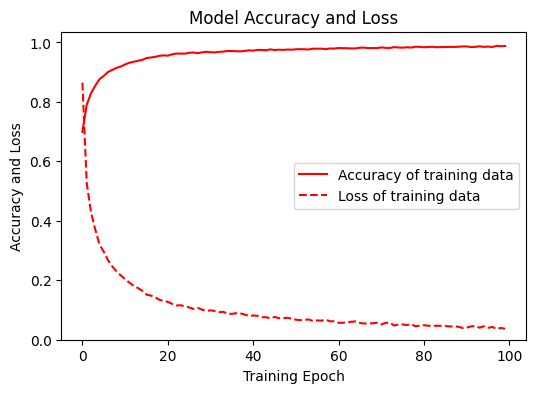

In [86]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


In [87]:
# Print confusion matrix for training data
y_pred_train = Cmodel.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis = 1)
print(classification_report(y_train, max_y_pred_train))

636/636 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      1788
         1.0       0.99      1.00      0.99      6569
         2.0       0.97      0.98      0.98      1049
         3.0       0.99      0.96      0.97       801
         4.0       0.98      0.77      0.86      2269
         5.0       1.00      0.99      0.99      7858

    accuracy                           0.96     20334
   macro avg       0.95      0.95      0.94     20334
weighted avg       0.97      0.96      0.96     20334



## lstm

In [88]:
Lmodel = Sequential()
Lmodel.add(LSTM(32, return_sequences=True, input_shape=(input_shape,1), activation='relu'))
Lmodel.add(LSTM(32,return_sequences=True, activation='relu'))
Lmodel.add(MaxPool1D(pool_size=4, padding='same'))
Lmodel.add(GlobalAveragePooling1D())
Lmodel.add(BatchNormalization(epsilon=1e-06))
Lmodel.add(Dense(6))
Lmodel.add(Activation('softmax'))

print(Lmodel.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 240, 32)        │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 240, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │           198 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,998 (50.77 KB)

 Trainable params: 12,934 (50.52 KB)

 Non-trainable params: 64 (256.00 B)

None


In [89]:
Lmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = Lmodel.fit(x_train,
                    y_train_hot,
                    batch_size= 192,
                    epochs=100
                   )

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 44s 369ms/step - accuracy: 0.5773 - loss: 1.3048
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 41s 364ms/step - accuracy: 0.7583 - loss: 0.7281
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 42s 370ms/step - accuracy: 0.7798 - loss: 0.6226
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 40s 380ms/step - accuracy: 0.8007 - loss: 0.5541
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 41s 379ms/step - accuracy: 0.8107 - loss: 0.5143
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 41s 379ms/step - accuracy: 0.8106 - loss: 0.5036
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 42s 387ms/step - accuracy: 0.8330 - loss: 0.4468
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 81s 377ms/step - accuracy: 0.8327 - loss: 0.4431
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 41s 378ms/step - accuracy: 0.8523 - loss: 0.4038
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 40s 374ms/step - accuracy: 0.8518 - loss: 0.4059
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 41s 371ms/step - accuracy: 0.8593 - loss: 0.3723
Epoch 12

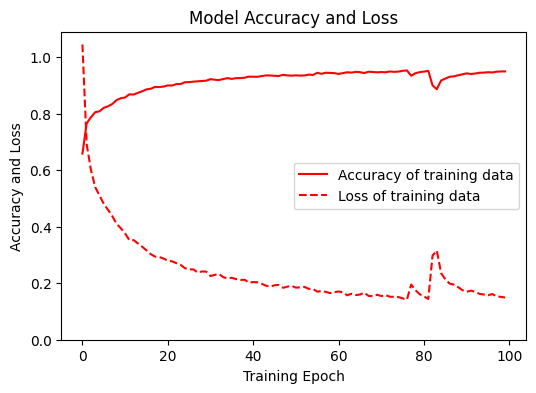

In [90]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


In [92]:
score = Lmodel.evaluate(x_test, y_test)
print("Accuracy:", score[1])
print("Loss:", score[0])


223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.6787 - loss: 1.7299
Accuracy: 0.6300927400588989
Loss: 1.6559644937515259


223/223 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step


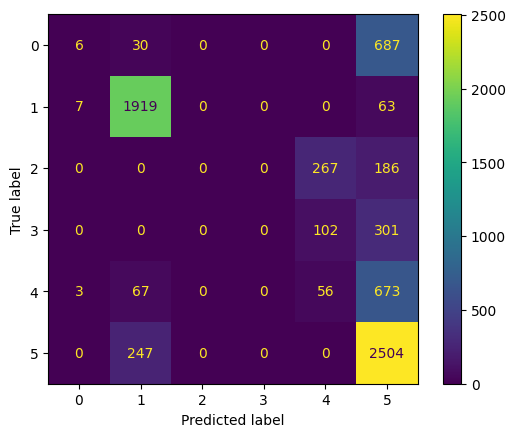

              precision    recall  f1-score   support

           0       0.38      0.01      0.02       723
           1       0.85      0.96      0.90      1989
           2       0.00      0.00      0.00       453
           3       0.00      0.00      0.00       403
           4       0.13      0.07      0.09       799
           5       0.57      0.91      0.70      2751

    accuracy                           0.63      7118
   macro avg       0.32      0.33      0.28      7118
weighted avg       0.51      0.63      0.53      7118



In [93]:
predictions = Lmodel.predict(x_test)
predictions = np.argmax(predictions, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()
print(classification_report(y_test_pred, predictions))

##CNN+LSTM

In [94]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(input_shape,1), activation='relu'))
model.add(LSTM(32,return_sequences=True, activation='relu'))
model.add(Reshape((240, 32))) # Remove the extra dimension
model.add(Conv1D(filters=64,kernel_size=2, activation='relu', strides=2))
model.add(Reshape((120, 64)))
model.add(MaxPool1D(pool_size=4, padding='same'))
model.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
model.add(Reshape((29, 192)))
model.add(GlobalAveragePooling1D())
model.add(BatchNormalization(epsilon=1e-06))
model.add(Dense(6))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 240, 32)        │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 240, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 240, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 120, 64)        │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 29, 192)        │        24,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 29, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 192)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 192)            │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │         1,158 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,526 (170.02 KB)

 Trainable params: 43,142 (168.52 KB)

 Non-trainable params: 384 (1.50 KB)

None


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train,
                    y_train_hot,
                    batch_size= 192,
                    epochs=100
                   )

Epoch 1/100
 69/106 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5809 - loss: 1.2340

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()



In [ ]:
score = model.evaluate(x_test, y_test)
print("Accuracy:", score[1])
print("Loss:", score[0])


In [ ]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_pred, predictions)
cm_disp = ConfusionMatrixDisplay(confusion_matrix= cm)
cm_disp.plot()
plt.show()
print(classification_report(y_test_pred, predictions))